In [1]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pacmap
import umap
import trimap

from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness


from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans


%matplotlib inline


In [ ]:
os.chdir("L:/lab_research/RES-Folder-UPOD/Celldynclustering")
celldyn = pd.read_sas("E_ResearchData/2_ResearchData/celldyn.sas7bdat")

D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [3]:
celldyn_full = pd.read_csv("L:/laupodteam/AIOS/Huibert-Jan/Celldynclustering/Data/data_no_c_s_45.csv")

with open("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\sample_indices.txt",'r') as f:
    samples = [int(x) for x in f.read().split("\n")[:-1]]
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]

In [2]:

def sigmoid(x):
    #return np.tanh(x)
    return 1/(1+np.exp(-x))

def sigmoid_log(x):
    return sigmoid(np.log(x))

In [4]:
droplist = ['c_b_wvf', 'c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']
sl_list = ['c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst','c_b_mone','c_b_mon','c_b_bas',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']
log_list = ['c_b_wbc','c_b_neu','c_b_seg','c_b_lym','c_b_eos',]

final_columns = list(set(meas_columns)-set(droplist))


q_scaler = FunctionTransformer(func=lambda x: np.maximum(np.quantile(x,0.001), np.minimum(np.quantile(x, 0.999), x)))
sl_scaler = FunctionTransformer(func=sigmoid_log)
wvf_scaler = FunctionTransformer(func=lambda x: np.maximum(0.90,(np.minimum(1, x))))
log_scaler = FunctionTransformer(func=lambda x: np.log(x+1))

transformer_list = [('wvf_scaler', wvf_scaler, ['c_b_wvf']),
                    ('q_scaler', q_scaler, final_columns),
                    ('sl_scaler', sl_scaler, sl_list),
                    ('log_scaler',log_scaler, log_list)]

pre_transformer = ColumnTransformer(transformer_list,remainder = 'passthrough')


In [18]:
sample_df = celldyn_full.sample(200000)
sample_df = sample_df
reduce_dim = 10


embedder_full = trimap.TRIMAP(n_dims = reduce_dim,n_inliers = 12, n_outliers = 4,n_random = 3,lr = 0.1,distance = 'manhattan')
le_pipe = Pipeline([('scaler_1', pre_transformer),                    
                    ('scaler_2', StandardScaler()),
                    ('embedder', embedder_full)])

le_pipe.fit(sample_df[meas_columns]) # final_columns

TRIMAP(n_inliers=12, n_outliers=4, n_random=3, distance=manhattan, lr=0.1, n_iters=400, weight_adj=500.0, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)
running TriMap on 200000 points with dimension 88
pre-processing
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100, Loss: 40112.605, Violated triplets: 0.3933
Iteration:  200, Loss: 40037.668, Violated triplets: 0.3925
Iteration:  300, Loss: 28204.490, Violated triplets: 0.2765
Iteration:  400, Loss: 13474.769, Violated triplets: 0.1321
Elapsed time: 0:14:09.467925


Pipeline(steps=[('scaler_1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('wvf_scaler',
                                                  FunctionTransformer(func=<function <lambda> at 0x00000214A81FA3A0>),
                                                  ['c_b_wvf']),
                                                 ('q_scaler',
                                                  FunctionTransformer(func=<function <lambda> at 0x00000214A81FAEE0>),
                                                  ['c_b_Ppcv', 'c_b_namn',
                                                   'c_b_mch_Usa', 'c_b_plto',
                                                   'c_b_pmone', 'c_b_seg',
                                                   'c_b_mchc_usa', 'c_b_pHPO',
                                                   '...
                ('scaler_2', StandardScaler()),
                ('embedder',
                 TRIMAP(distance='manhattan

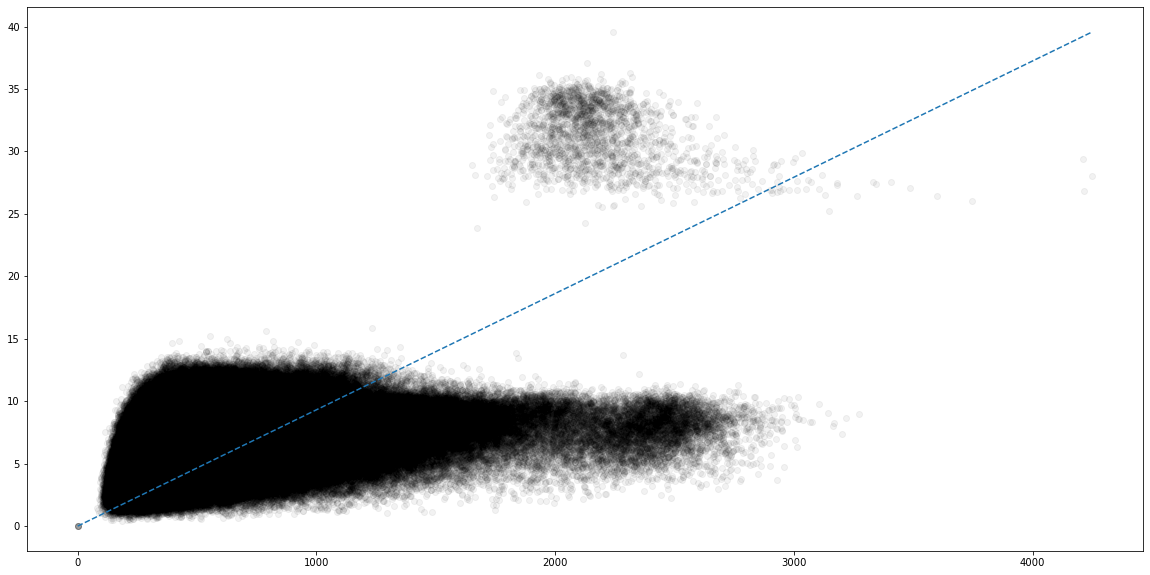

In [19]:
sample_selection = np.random.randint(0,200000,2000)
dist_before = distance.pdist(sample_df.reset_index(drop = True).loc[sample_selection,meas_columns],metric = 'cityblock')
dist_after = distance.pdist(le_pipe.named_steps['embedder'].embedding_[sample_selection,:],metric = 'cityblock')


plt.figure(figsize = (20,10))
plt.scatter(dist_before,dist_after, alpha = 0.05,c ='black')
mx,my = max(dist_before), max(dist_after)
plt.plot([0,mx],[0,my],ls = "--")

In [20]:
clusterer_embedding = KMeans(n_clusters = 5)
clusterer_embedding.fit(le_pipe.named_steps['embedder'].embedding_)

KMeans(n_clusters=5)

In [21]:
clusterer_org_dat = KMeans(n_clusters = 5)
clusterer_org_dat.fit(StandardScaler().fit_transform(pre_transformer.fit_transform(sample_df[meas_columns])))

KMeans(n_clusters=5)

In [22]:
r_score =rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
ar_score = adjusted_rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
mi_score = adjusted_mutual_info_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)

c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))


In [23]:
ch_score1 = calinski_harabasz_score(sample_df[meas_columns], clusterer_org_dat.labels_)
ch_score2 = calinski_harabasz_score(le_pipe.named_steps['embedder'].embedding_, clusterer_embedding.labels_)

db_score1 = davies_bouldin_score(sample_df[meas_columns], clusterer_org_dat.labels_)
db_score2 = davies_bouldin_score(le_pipe.named_steps['embedder'].embedding_, clusterer_embedding.labels_)

In [24]:
dist_preservation_overall = dcor.distance_correlation(dist_before, dist_after)

In [26]:
print("Distance preservation overall", dist_preservation_overall)
#print("Intra-distance trustworthiness", trustworthiness(sample_df[meas_columns], le_pipe.named_steps['embedder'].embedding_))
print("Rand score", r_score)
print("Adjusted Rand score", ar_score)
print("Adjusted MI score", mi_score)
print("Calinski-Harabasz ratio, lower than 1 means better clustering for embedding", ch_score1/ch_score2)
print("David-Bouldin ratio, higher than 1 means better clustering for embedding", db_score1/db_score2)

Distance preservation overall 0.3655083675919377
Rand score 0.7769290669453347
Adjusted Rand score 2.89375369139404
Adjusted MI score 0.521753796713522
Calinski-Harabasz ratio, lower than 1 means better clustering for embedding 0.22177375979090191
David-Bouldin ratio, higher than 1 means better clustering for embedding 1.9776008829961873


In [27]:
plot_df = pd.DataFrame(data=le_pipe.named_steps['embedder'].embedding_, columns=[f'd_{i}' for i in range(reduce_dim)], index=sample_df.index)
plot_df = plot_df.join(sample_df[mode_columns+alrt_columns])
plot_df['k_means']  = clusterer_embedding.labels_

plot_df['has_alrt'] = np.where(np.sum(plot_df[alrt_columns],axis = 1) >0.5,1,0)


In [28]:
from hdbscan import HDBSCAN

db_scan = HDBSCAN(min_samples= 50)
plot_df['labels'] = db_scan.fit_predict(plot_df[[f'd_{i}' for i in range(reduce_dim)]])

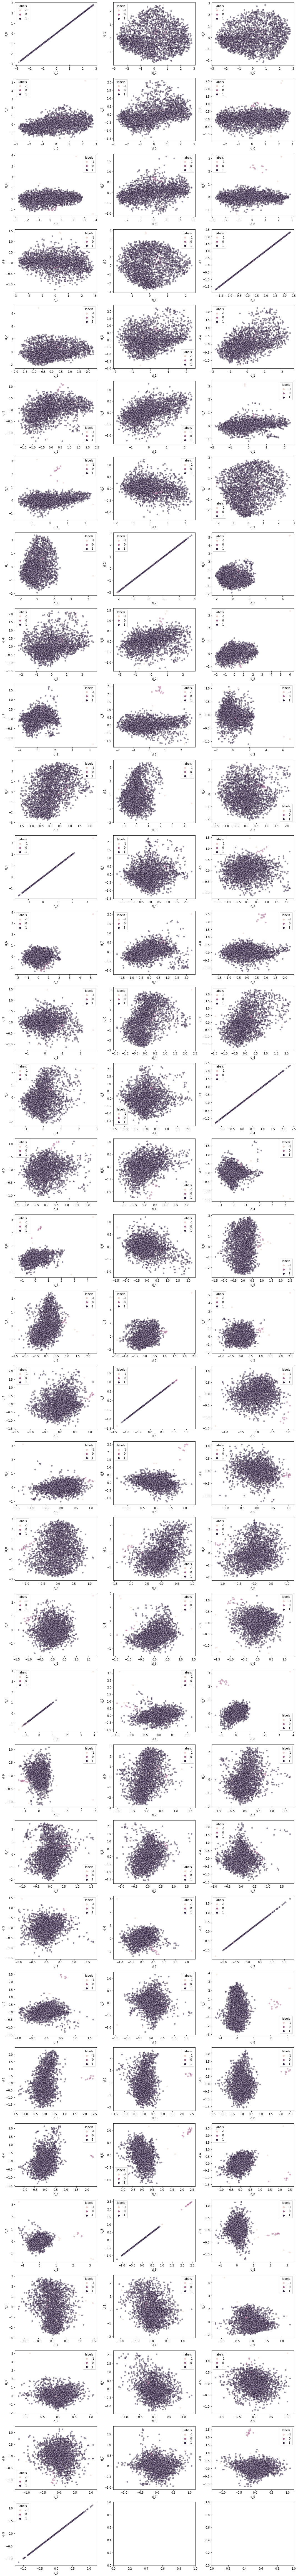

In [29]:
#reduce_dim = min([6, reduce_dim])
num_rows = int(np.ceil((reduce_dim)**2/3))
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
fig.patch.set_facecolor("white")

for ki in range(reduce_dim):
    for kj in range(reduce_dim): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[i,j], 
                            hue='labels', alpha=0.5)
        else:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[k], 
                            hue='labels', alpha=0.5)
        k += 1